# Libraries 📖

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import squarify
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Database 📂

## Upload Database ⬆️

In [2]:
conn = sqlite3.connect("../data/olist.sqlite")
c = conn.cursor()

In [3]:
# write the query
query = """
SELECT
	or2.review_score,
    op.payment_type,
    op.payment_installments,
    op.payment_value,
    oi.freight_value/oi.price AS freight_weight,
    MAX(oi.order_item_id) AS item_per_order,
    julianday(o.order_delivered_customer_date)- julianday(o.order_approved_at) AS delivery_time,
    gld.distance_km
FROM orders o
INNER JOIN order_items oi ON oi.order_id = o.order_id
INNER JOIN order_reviews or2 ON or2.order_id = o.order_id 
INNER JOIN order_payments op ON op.order_id = o.order_id
INNER JOIN geo_loc_det gld ON gld.order_id = o.order_id
INNER JOIN products p ON p.product_id = oi.product_id 
WHERE o.order_status == 'delivered' AND 
p.product_category_name IS NOT NULL AND 
p.product_category_name = "beleza_saude" OR "relogios_presentes" OR "cama_mesa_banho" OR "esporte_lazer" OR "informatica_acessorios"
GROUP BY oi.order_id
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
df_ml = pd.read_sql_query(query, conn)

## Clear 🧹

In [4]:
df_ml.isna().sum()

review_score            0
payment_type            0
payment_installments    0
payment_value           0
freight_weight          0
item_per_order          0
delivery_time           0
distance_km             0
dtype: int64

In [5]:
df_ml = df_ml.dropna()
df_ml.isna().sum()

review_score            0
payment_type            0
payment_installments    0
payment_value           0
freight_weight          0
item_per_order          0
delivery_time           0
distance_km             0
dtype: int64

In [6]:
df_ml.shape

(8573, 8)

## Balance ⚖️

In [7]:
df_ml['review_score'].value_counts()

5    5356
4    1573
1     776
3     661
2     207
Name: review_score, dtype: int64

In [8]:
# Define rating_cat as customer satisfaction (1 for yes, 0 for no)
def convert_score(valor):
    if valor < 4:
        return 0
    elif valor > 4:
        return 1
    
df_ml['review_score'] = df_ml['review_score'].apply(convert_score)
df_ml['review_score'].value_counts()

1.0    5356
0.0    1644
Name: review_score, dtype: int64

In [9]:
# Separate majority and minority classes
df_majority = df_ml[df_ml['review_score'] == 1]
df_minority = df_ml[df_ml['review_score'] == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class size
                                   random_state=42)  # for reproducibility

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class distribution
print(df_balanced['review_score'].value_counts())

1.0    1644
0.0    1644
Name: review_score, dtype: int64


## Encode ⚙️

In [10]:
%%time
# Encode categorical columns
ohe = OneHotEncoder(sparse_output = False)
ohe.fit(df_balanced[['payment_type']])
df_balanced[ohe.get_feature_names_out()] = ohe.transform(df_balanced[['payment_type']])
df_encoded = df_balanced.drop(columns = ["payment_type"])
df_encoded

CPU times: user 2.17 ms, sys: 809 µs, total: 2.98 ms
Wall time: 2.81 ms


,review_score,payment_installments,payment_value,freight_weight,item_per_order,delivery_time,distance_km,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
8030,1.0,10,347.41,0.052758,1,1.952164,883.335209,0.0,1.0,0.0,0.0
2745,1.0,1,43.08,1.051429,1,5.650475,844.137976,0.0,1.0,0.0,0.0
675,1.0,1,199.24,0.054180,1,9.581273,118.372102,1.0,0.0,0.0,0.0
6797,1.0,10,239.42,0.088273,1,6.493125,296.262661,0.0,1.0,0.0,0.0
2788,1.0,1,68.25,0.483696,1,24.902789,1088.503270,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8556,0.0,1,75.65,0.282421,1,10.126273,493.409233,1.0,0.0,0.0,0.0
8557,0.0,1,128.97,0.169054,1,21.014236,393.192465,0.0,1.0,0.0,0.0
8562,0.0,1,69.44,1.105518,2,23.302037,746.121250,0.0,1.0,0.0,0.0
8569,0.0,5,108.61,0.553791,1,30.949340,2251.749415,0.0,1.0,0.0,0.0


In [11]:
df_encoded.isna().sum()

review_score                0
payment_installments        0
payment_value               0
freight_weight              0
item_per_order              0
delivery_time               0
distance_km                 0
payment_type_boleto         0
payment_type_credit_card    0
payment_type_debit_card     0
payment_type_voucher        0
dtype: int64

# Data exploration 🔍

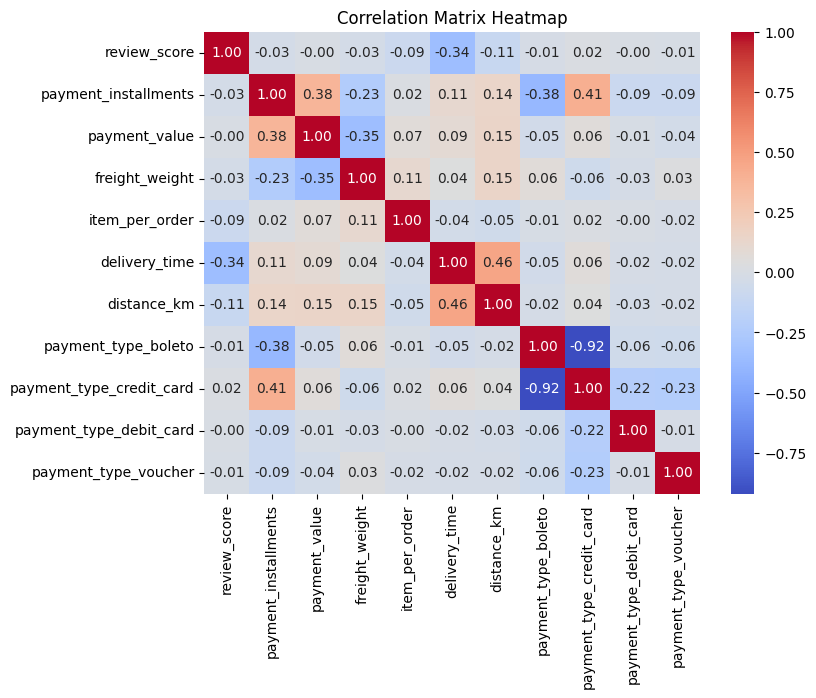

In [12]:
# Plotting the correlation matrix as a heatmap
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Modeling - DecisionTreeClassifier 🤖

## Split Database

In [13]:
# # Split data - train and test
X = df_encoded.drop(['review_score'], axis=1)
y = df_encoded['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tunning model

In [14]:
# Creation of the random forest model

DTC_model = DecisionTreeClassifier(random_state=42)

### Random Search

In [15]:
# Define the hyperparameter grid
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 5, 6, 7, 8, 10, 20, 30, 40, 50],
    'min_samples_split': stats.randint(2, 100),
    'min_samples_leaf': stats.randint(1, 100)
}

In [16]:
%%time
random_search = RandomizedSearchCV(
    estimator=DTC_model,
    param_distributions=param_dist,
    n_iter=500,
    cv=7,
    n_jobs=-1,
    random_state=42
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best score
print(f"Best cross-validation score: {random_search.best_score_}")

Best cross-validation score: 0.6615876393110437
CPU times: user 1.48 s, sys: 336 ms, total: 1.82 s
Wall time: 2.75 s


In [17]:
random_search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 96,
 'min_samples_split': 50,
 'splitter': 'best'}

In [18]:
best_par = random_search.best_params_
DTC_model = DecisionTreeClassifier(**best_par, random_state=42)
best_par

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 96,
 'min_samples_split': 50,
 'splitter': 'best'}

In [19]:
%%time
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation with 5 folds
cv_results = cross_validate(DTC_model, X_train, y_train, cv=7, scoring=scoring, return_train_score=True)

# Output the cross-validation results
print("Cross-Validation Results:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Test Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Test Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Test F1 Score: {cv_results['test_f1'].mean():.4f}")

Cross-Validation Results:
Train Accuracy: 0.6625
Test Accuracy: 0.6616
Test Precision: 0.6069
Test Recall: 0.8880
Test F1 Score: 0.7208
CPU times: user 76.2 ms, sys: 0 ns, total: 76.2 ms
Wall time: 75.9 ms


## Modeling check

In [20]:
%%time
train_sizes = np.arange(50, 2000, 50, dtype=int)

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=DTC_model, X=X_train, y=y_train, train_sizes=train_sizes, cv=7)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

CPU times: user 838 ms, sys: 242 µs, total: 838 ms
Wall time: 837 ms


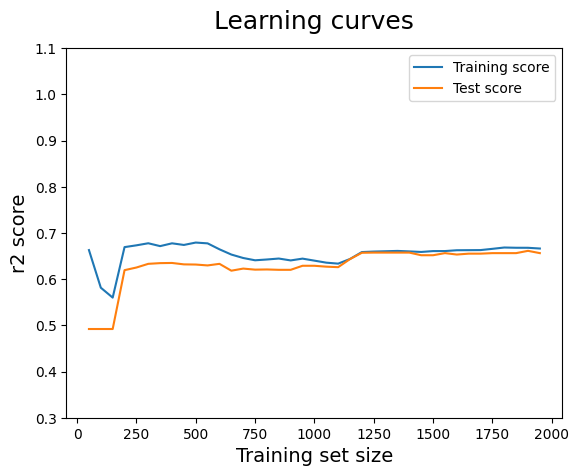

In [21]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0.3,1.1)
plt.legend();

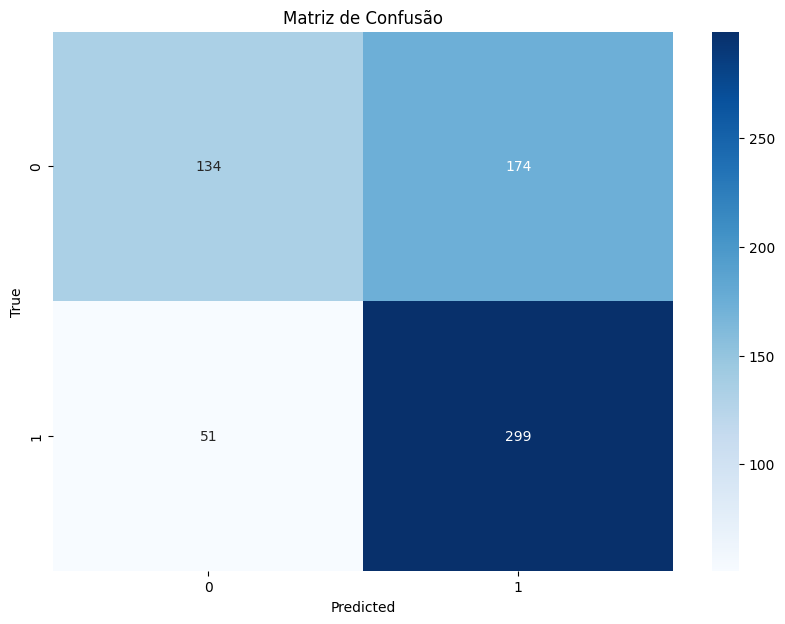

In [22]:
DTC_model.fit(X_train, y_train)
y_pred = DTC_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

## Feature Importances

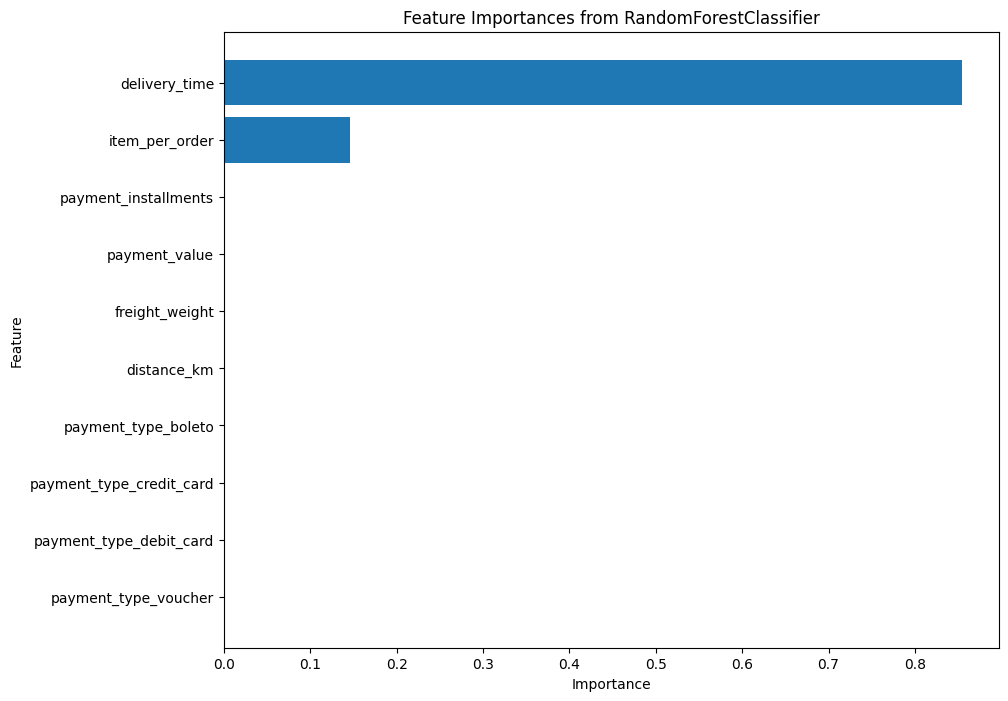

In [23]:
# Get feature importances
importances = DTC_model.feature_importances_
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(len(importances))]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()